In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['download_datasets.py', 'face_feature.py', 'det2.npy', 'imdb.mat', 'det1.npy', 'main.py', 'architecture', 'align_custom.py', 'Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4', 'model-20170512-110547.ckpt-250000.index', 'tf_graph.py', 'facerec_128D_got.txt', 'inception_resnet_v1.py', 'imdb00', 'model-20170512-110547.ckpt-250000.data-00000-of-00001', 'det3.npy', 'mtcnn_detect.py']


# Objective

Detect and recognize the faces in the following youtube video:

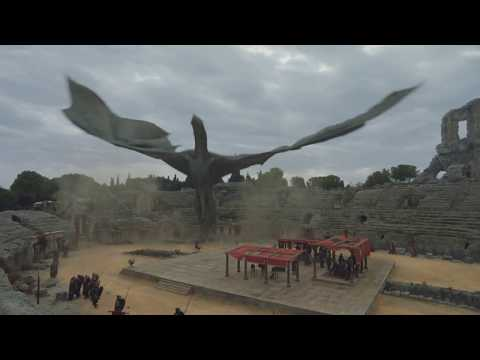

In [18]:
from IPython.display import HTML
from IPython.display import YouTubeVideo

#HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/403jzB62dAs?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')
YouTubeVideo('403jzB62dAs')

# imports

In [2]:
import os

# change directory to the dataset where our
# custom scripts are found
os.chdir("/kaggle/input/")

from align_custom import AlignCustom
from face_feature import FaceFeature
from mtcnn_detect import MTCNNDetect
from tf_graph import FaceRecGraph

In [3]:
import os, sys, glob
import cv2

import argparse
import sys
import json
import numpy as np
from sklearn.cluster import KMeans
import time

import scipy
import scipy.io as sio
from scipy.io import loadmat
from datetime import datetime
import pandas as pd
import time

# Detection and Recgnition

Based and Inspired by:
- **https://github.com/vudung45/FaceRec
- Augmentation code: https://github.com/vxy10/ImageAugmentation
- Fancy borders: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/

Description:
- Images from Video Capture -> detect faces' regions -> crop those faces and align them 
- each cropped face is categorized in 3 types: Center, Left, Right 
- Extract 128D vectors( face features)
- Search for matching subjects in the dataset based on the types of face positions. 
- The preexisitng face 128D vector with the shortest distance to the 128D vector of the face on screen is most likely a match
(Distance threshold is 0.6, percentage threshold is 70%)
    

# Generate Face DB

In [4]:
dict_faces = dict()
dict_faces["Jaime Lannister"] = ["https://s2.r29static.com//bin/entry/97f/340x408,85/1832698/image.jpg",
                                "https://upload.wikimedia.org/wikipedia/en/thumb/b/b4/Jaime_Lannister-Nikolaj_Coster-Waldau.jpg/220px-Jaime_Lannister-Nikolaj_Coster-Waldau.jpg",
                                 "https://upload.wikimedia.org/wikipedia/pt/thumb/0/06/Nikolaj-Coster-Waldau-Game-of-Thrones.jpg/220px-Nikolaj-Coster-Waldau-Game-of-Thrones.jpg",
                                 "https://purewows3.imgix.net/images/articles/2017_09/jaime-lannister-season-7-game-of-thrones-finale1.jpg?auto=format,compress&cs=strip&fit=min&w=728&h=404",
                                 "https://cdn.newsday.com/polopoly_fs/1.13944684.1502107079!/httpImage/image.jpeg_gen/derivatives/landscape_768/image.jpeg",
                                 "https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png",
                                 "https://fsmedia.imgix.net/9c/c0/27/10/15e0/44a4/8ecb/9339993b563d/nikolaj-coster-waldau-as-jaime-lannister-in-game-of-thrones-season-7.png?rect=0%2C0%2C1159%2C580&dpr=2&auto=format%2Ccompress&w=650",
                                 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrIQuBKKUocAizwfWtIdhAcvfowLJatKqqDsO3ywYdh3rv-mBk"
                                ]

In [5]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

def read_image_from_url(url2read):
    req = urllib.request.urlopen(url2read)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) # 'Load it as it is'
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)

https://s2.r29static.com//bin/entry/97f/340x408,85/1832698/image.jpg
https://upload.wikimedia.org/wikipedia/en/thumb/b/b4/Jaime_Lannister-Nikolaj_Coster-Waldau.jpg/220px-Jaime_Lannister-Nikolaj_Coster-Waldau.jpg
https://upload.wikimedia.org/wikipedia/pt/thumb/0/06/Nikolaj-Coster-Waldau-Game-of-Thrones.jpg/220px-Nikolaj-Coster-Waldau-Game-of-Thrones.jpg
https://purewows3.imgix.net/images/articles/2017_09/jaime-lannister-season-7-game-of-thrones-finale1.jpg?auto=format,compress&cs=strip&fit=min&w=728&h=404
https://cdn.newsday.com/polopoly_fs/1.13944684.1502107079!/httpImage/image.jpeg_gen/derivatives/landscape_768/image.jpeg
https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png
https://fsmedia.imgix.net/9c/c0/27/10/15e0/44a4/8ecb/9339993b563d/nikolaj-coster-waldau-as-jaime-lannister-in-game-of-thrones-season-7.png?rect=0%2C0%2C1159%2C580&dpr=2&auto=format%2Ccompress&w=650
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrIQuBKKUocAizwfWtIdhAcvfow

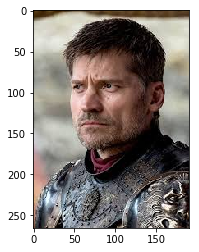

In [6]:
# Check urls and print last image
for p in dict_faces.keys():
    urls = dict_faces[p]
    for url2read in urls:
        print(url2read)
        img = read_image_from_url(url2read)
plt.imshow(img)            

## Generate Face DB Functions

In [7]:
def import_from_images():
    print()
    print("[INFO] Extracting data from images ...")
    data_set = dict()

    for new_name in dict_faces.keys():
        person_features = {"Left" : [], "Right": [], "Center": []};
        print("Extracting:",new_name)
        print("number of img files:",len(dict_faces[new_name]))
        person_imgs = get_person_imgs(dict_faces[new_name]) 
        if person_imgs is None:
            print("extraction of:",new_name, " failed")
            continue
        
        print("extracted person_imgs from:",new_name)

        for pos in person_imgs: #there r some exceptions here, but I'll just leave it as this to keep it simple
            person_features[pos] = [np.mean(extract_feature.get_features(person_imgs[pos]),axis=0).tolist()]
        data_set[new_name] = person_features;
        
    f = open('/kaggle/working/facerec_128D.txt', 'w+'); 
    f.write(json.dumps(data_set))
    
    
def get_person_imgs(urls):
    person_imgs = {"Left" : [], "Right": [], "Center": []};
    person_imgs_count = {"Left" : 0, "Right": 0, "Center": 0};
    #num_aug_factor = 2
    #if int(50/len(img_files))+1 > num_aug_factor:
    #    num_aug_factor = int(50/len(img_files))+1        
    #person_features = {"Left" : [], "Right": [], "Center": []};
    #print("Please start turning slowly. Press 'q' to save and add this new user to the dataset");
    #while True:
    counter_break = 0
    while True:    
        for url2read in urls:  
            #print(file)
            #ret, frame = vs.read()
            #img = cv2.imread(file)
            img = read_image_from_url(url2read) # ****** file = url2read
            if img is None:
                print("********************* image was not loaded ***********************")
                continue

            flip_img = cv2.flip(img, 1)
            frames = [img, flip_img]

            #for i in range(num_aug_factor):
            #    frames.append(transform_image(img,20,10,5,brightness=1))
            #for i in range(num_aug_factor):
            #    frames.append(transform_image(flip_img,20,10,5,brightness=1))    

            for frame in frames:
                if True: #ret:
                    rects, landmarks = face_detect.detect_face(frame, 40);  # min face size is set to 80x80
                    #print("rects", rects)
                    for (i, rect) in enumerate(rects):
                        aligned_frame, pos = aligner.align(160,frame,landmarks[i]);
                        #print(pos)
                        person_imgs_count[pos]+=1
                        if len(aligned_frame) == 160 and len(aligned_frame[0]) == 160:
                            person_imgs[pos].append(aligned_frame)
                            #cv2.imshow("Captured face", aligned_frame)
                            #cv2.imwrite("../data2/frame%d.jpg" % count, aligned_frame)
                    key = cv2.waitKey(1) & 0xFF
                    if key == ord("q"):
                        break
                else:
                    break
            
        if person_imgs_count["Left"] == 0 or person_imgs_count["Right"] == 0 or person_imgs_count["Center"] == 0:
            counter_break+=1
            if counter_break > 3:
                print(person_imgs_count)  
                return None
        else:
            break
                            
    print(person_imgs_count)    
    return(person_imgs)  

# Face Recognition in Video Functions

In [8]:
def video_file_recog():
    print("[INFO] Reading video file ...")
    #vs = cv2.VideoCapture(0); #get input from webcam
    video_file = "Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"
    if glob.glob(video_file):
        vs = cv2.VideoCapture(video_file); #get input from file
    else:
        print("file does not exist")
        return
    
    frame_width = int(vs.get(3))
    frame_height = int(vs.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # DIVX, XVID, MJPG, X264, WMV1, WMV2, mp4v
    framerate = 30.0 # 20.0 / 30.0
    video_path = "/kaggle/working/"
    out = cv2.VideoWriter(video_path+'output.mp4', fourcc, framerate, (frame_width,frame_height))
    
    unknown_counter = 0
    known_counter = 0
    t0 = time.time()
    while True:        
        ret,frame = vs.read();
        if ret:
            #u can certainly add a roi here but for the sake of a demo i'll just leave it as simple as this
            min_face_size = 80 #min face size is set to 80x80 40 / 20
            rects, landmarks = face_detect.detect_face(frame,min_face_size);
            aligns = []
            positions = []
            for (i, rect) in enumerate(rects):
                print(str(i))
                aligned_face, face_pos = aligner.align(160,frame,landmarks[i])
                if len(aligned_face) == 160 and len(aligned_face[0]) == 160:
                    aligns.append(aligned_face)
                    positions.append(face_pos)
                else: 
                    print("Align face failed") #log        
            if(len(aligns) > 0):
                features_arr = extract_feature.get_features(aligns)
                recog_data = findPeople(features_arr,positions);              
                print("recog_data", str(recog_data))
                for (i,rect) in enumerate(rects):
                    shrtname = short_name(recog_data[i][0])
                    acc = round(recog_data[i][1],1)
                    if "Unknown" in recog_data[i][0]:
                        unknown_counter+=1
                        #cv2.rectangle(frame,(rect[0],rect[1]),(rect[0] + rect[2],rect[1]+rect[3]),(255,255,255)) 
                        #draw bounding box for the face
                        draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (255,255,255), 1, 10, 10)
                        cv2.putText(frame,shrtname+"-"+str(round(recog_data[i][1],1))+"%",
                                    (rect[0]-4,rect[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                    (255,255,255),1,cv2.LINE_AA)
                    else:
                        known_counter+=1
                        #cv2.rectangle(frame,(rect[0],rect[1]),(rect[0] + rect[2],rect[1]+rect[3]),(124,252,0)) 
                        # draw a fancy border around the faces
                        #draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (162, 255, 0), 2, 10, 10)
                        draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (124,252,0), 1, 10, 10)  
                        #draw bounding box for the face
                        cv2.putText(frame,shrtname+"-"+str(round(recog_data[i][1],1))+"%",
                                    (rect[0]-4,rect[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                    (124,252,0),1,cv2.LINE_AA)                        
                    # changing (255,0,0) --> (124,252,0), from blue to green
                    # changing (255,255,255) --> (124,252,0), from white to green
                    # changing (255,0,0) --> (255,255,255), from blue to white

            #cv2.imshow("Frame",frame)
            #cv2.imwrite("../data3/frame%d.jpg" % count, frame)
            out.write(frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("q"):
                break
        else:
            break
    
    elapsed_time = time.time() - t0
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    print("known_counter:",known_counter, "unknown_counter:",unknown_counter)
    
    print()
    print("Done")

In [9]:
def findPeople(features_arr, positions, thres = 0.6, percent_thres = 70):
    '''
    :param features_arr: a list of 128d Features of all faces on screen
    :param positions: a list of face position types of all faces on screen
    :param thres: distance threshold
    :return: person name and percentage
    '''
    #f = open('./facerec_128D.txt','r')
    f = open('/kaggle/working/facerec_128D.txt','r')
    data_set = json.loads(f.read());
    returnRes = [];
    for (i,features_128D) in enumerate(features_arr):
        result = "Unknown";
        smallest = sys.maxsize
        for person in data_set.keys():
            person_data = data_set[person][positions[i]];
            #print("positions["+str(i)+"]",positions[i])
            for data in person_data:
                distance = np.sqrt(np.sum(np.square(data-features_128D)))
                if(distance < smallest):
                    smallest = distance;
                    result = person;
        percentage =  min(100, 100 * thres / smallest)
        if percentage <= percent_thres :
            result = "Unknown"
        returnRes.append((result,percentage))
    return returnRes

def short_name(name):
    name_split = name.split(" ")
    short_name = name_split[0]
    if len(name_split) > 1:
        short_name = short_name + "." + name_split[1][0]
    return(short_name)


# Fancy box drawing function by Dan Masek
# Code in: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/
def draw_border(img, pt1, pt2, color, thickness, r, d):
    x1, y1 = pt1
    x2, y2 = pt2
 
    # Top left drawing
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
 
    # Top right drawing
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
 
    # Bottom left drawing
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
 
    # Bottom right drawing
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness) 

# RUN

In [10]:
# initalize
FRGraph = FaceRecGraph();
aligner = AlignCustom();
extract_feature = FaceFeature(FRGraph)
face_detect = MTCNNDetect(FRGraph, scale_factor=2); #scale_factor, rescales image for faster detection

Loading model...
Model loaded
Loading MTCNN Face detection model
MTCNN Model loaded


## Generate face database

In [11]:
import_from_images()


[INFO] Extracting data from images ...
Extracting: Jaime Lannister
number of img files: 8
{'Left': 4, 'Right': 5, 'Center': 8}
extracted person_imgs from: Jaime Lannister


In [12]:
!ls ../working/ -ashl

total 28K
4.0K drwxr-xr-x 3 root root 4.0K Nov  7 09:26 .
4.0K drwxr-xr-x 6 root root 4.0K Nov  7 09:25 ..
4.0K drwxr-xr-x 2 root root 4.0K Nov  7 09:25 .ipynb_checkpoints
4.0K -rw-r--r-- 1 root root  199 Nov  7 09:25 __notebook_source__.ipynb
 12K -rw-r--r-- 1 root root 8.3K Nov  7 09:26 facerec_128D.txt


## Recognition in video file

In [13]:
video_file_recog()

[INFO] Reading video file ...
0
recog_data [('Jaime Lannister', 88.52420558866913)]
0
recog_data [('Jaime Lannister', 89.02179960434204)]
0
recog_data [('Jaime Lannister', 87.41371571236958)]
0
recog_data [('Unknown', 43.88652224568463)]
0
recog_data [('Unknown', 44.49626882844749)]
0
recog_data [('Unknown', 44.745836650515905)]
0
recog_data [('Unknown', 43.699822656368866)]
0
recog_data [('Unknown', 43.73829109610168)]
0
recog_data [('Unknown', 43.50138213058432)]
0
recog_data [('Unknown', 43.36308610404558)]
0
recog_data [('Unknown', 43.7278558296119)]
0
recog_data [('Unknown', 43.4607096088878)]
0
recog_data [('Unknown', 43.76178081760252)]
0
recog_data [('Unknown', 44.259551927340226)]
0
recog_data [('Unknown', 44.042794508398195)]
0
recog_data [('Unknown', 44.31948051962758)]
0
recog_data [('Unknown', 43.88060967061343)]
0
recog_data [('Unknown', 43.960229222436084)]
0
recog_data [('Unknown', 44.08091606358953)]
0
recog_data [('Unknown', 43.95466241303998)]
0
recog_data [('Unknown

In [14]:
!ls ../working/ -ashl

total 16M
4.0K drwxr-xr-x 3 root root 4.0K Nov  7 09:26 .
4.0K drwxr-xr-x 6 root root 4.0K Nov  7 09:25 ..
4.0K drwxr-xr-x 2 root root 4.0K Nov  7 09:25 .ipynb_checkpoints
4.0K -rw-r--r-- 1 root root  199 Nov  7 09:25 __notebook_source__.ipynb
 12K -rw-r--r-- 1 root root 8.3K Nov  7 09:26 facerec_128D.txt
 16M -rw-r--r-- 1 root root  16M Nov  7 09:26 output.mp4


# Questions

- Download movie output.mp4 and check who was recognized and how many times?
- Add more individulas to the database so you could recgnize more individuals
- Try to change min_face_size and see if you can recgnize faces in more frames
- How would you increase the accuracy of the recgnition?
- How would you make the entire process run faster?